### Install Required Packages

We would be running Facebook's `Detic` so enable `GPU` under `View Resources > Change runtime type` for faster inference.

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f076c3db-040b-e689-8f10-7bbcbb9a4d1a)


#### Detic

We install `Detectron2` as `Detic` requires it for running the models.

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.6'
# clone and install Detic
!git clone https://github.com/facebookresearch/Detic.git --recurse-submodules
%cd Detic
!pip install -r requirements.txt

### Load Necessary Libraries

We will load the necessary libraries, which would be required to run Inference with Detic and Configure it.

In [ ]:
# General
import sys
import os
import json
import random
from pathlib import Path
from typing import Iterable, List, NamedTuple

# Plotting and Image Processing
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

# Math and Data Handling
import numpy as np
from numpy import ndarray
from torch.utils.data import DataLoader, Dataset

# PyTorch
import torch

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
import detectron2.data.transforms as T
from detectron2.modeling import build_model
from detectron2.structures import Instances
from detectron2.engine import DefaultPredictor
from detectron2.config import CfgNode, get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import MetadataCatalog, DatasetCatalog


# Detic libraries
sys.path.insert(0, 'third_party/CenterNet2/') # -----> Make sure your Detic folder has this folder (clone it if required)
from centernet.config import add_centernet_config
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test

### Setup Detic

Configure `Detic` below and download its pretrained weights.

In [ ]:
# Obtain Detectron2's default config
cfg = get_cfg() 
# Add CenterNet config to our config (Detic uses it for anchorless Object Detection)
add_centernet_config(cfg)
# Add Detic config to our config
add_detic_config(cfg)
# Add config values from file
cfg.merge_from_file("configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")
# Add link to weights for Detic
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'

# Filter our low score Regions proposed hence set threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  
cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
# For better visualization purpose. Set to False for all classes.
cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True 

# cfg.MODEL.DEVICE='cpu' # uncomment this to use cpu-only mode.
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth: 702MB [00:41, 17.0MB/s]                           


The following are the built-in (some from `Detectron2` and some from `Detic`) vocabularies available.

In [ ]:
BUILDIN_CLASSIFIER = {
    'lvis': 'datasets/metadata/lvis_v1_clip_a+cname.npy',
    'objects365': 'datasets/metadata/o365_clip_a+cnamefix.npy',
    'openimages': 'datasets/metadata/oid_clip_a+cname.npy',
    'coco': 'datasets/metadata/coco_clip_a+cname.npy',
}

BUILDIN_METADATA_PATH = {
    'lvis': 'lvis_v1_val',
    'objects365': 'objects365_v2_val',
    'openimages': 'oid_val_expanded',
    'coco': 'coco_2017_val',
}

Choose your vocabulary from one of the above.

In [ ]:
vocabulary = 'coco' # change to 'lvis', 'objects365', 'openimages', or 'coco'

In [ ]:
# Setup the model's vocabulary using build-in datasets
metadata = MetadataCatalog.get(BUILDIN_METADATA_PATH[vocabulary])
classifier = BUILDIN_CLASSIFIER[vocabulary]
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)

Resetting zs_weight datasets/metadata/coco_clip_a+cname.npy


### Load Data

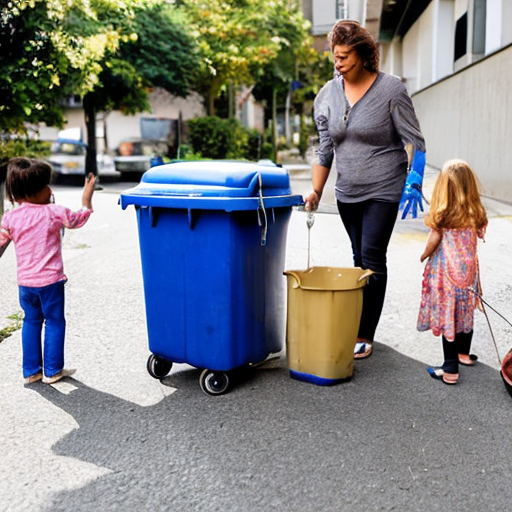

In [ ]:
# Single Image Inference
im = cv2.imread('1_1.png')
cv2_imshow(im)

### Inference Detic

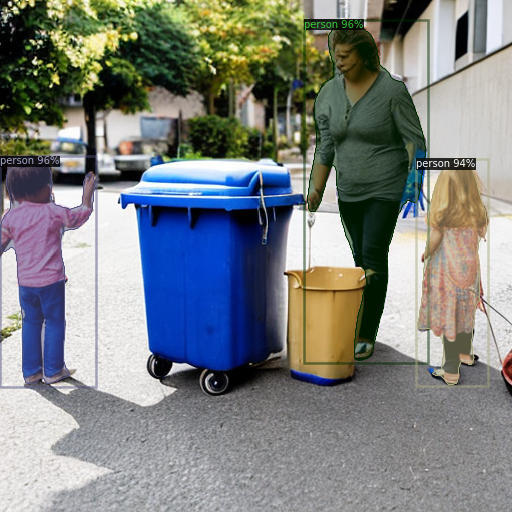

In [ ]:
# Run model and show results
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
type(outputs['instances'])

detectron2.structures.instances.Instances